<a href="https://colab.research.google.com/github/rhiga2/AIHawaii/blob/main/papers/autoencoders/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
!pip install pytorch_lightning
!pip install lightning

In [ ]:
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split

# Define the path where the MNIST dataset will be downloaded
data_path = '/content'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download the MNIST training dataset
train_dataset = datasets.MNIST(
    root=data_path,
    train=True,
    download=True,
    transform=transform,
)

# Download the MNIST test dataset
test_dataset = datasets.MNIST(
    root=data_path,
    train=False,
    download=True,
    transform=transform,
)

# Split the training dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


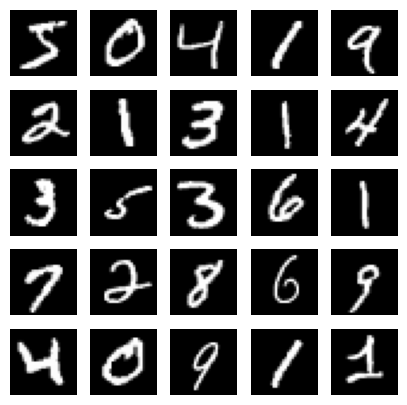

Image shape:  torch.Size([28, 28])


In [ ]:
import matplotlib.pyplot as plt

images = train_dataset.dataset.data[:25]
fig, axes = plt.subplots(5, 5, figsize=(5, 5))

def show_grid(images, fig, axes):
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    plt.show()

show_grid(images, fig, axes)
print('Image shape: ', images[0].shape)


In [ ]:
from torch.utils.data import DataLoader
batch_size=64

# Create a data loader for the training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create a data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class ConvEncoder(pl.LightningModule):
    def __init__(self, in_channels = 1,
                 out_channels = 16,
                 latent_dim = 64,
                 act_fn = nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # (28, 28)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (14, 14)
            act_fn,
            nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (7, 7)
            act_fn,
            nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(4*out_channels*7*7, latent_dim),
            act_fn
        )

    def forward(self, x):
        encoded = self.net(x)
        return encoded

In [ ]:
class ConvDecoder(pl.LightningModule):
    def __init__(self,
                 in_channels = 1,
                 out_channels = 16,
                 latent_dim = 64,
                 act_fn = nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 4*out_channels*7*7),
            act_fn,
            nn.Unflatten(1, (4*out_channels, 7, 7)),
            nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (7, 7)
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1,
                            stride=2, output_padding=1), # (14, 14)
            act_fn,
            nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1,
                            stride=2, output_padding=1), # (28, 28)
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
        )

    def forward(self, x):
        decoded = self.net(x)
        return decoded


In [ ]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, in_channels = 1,
                 out_channels = 16,
                 latent_dim = 64,
                 act_fn = nn.ReLU()):
        super().__init__()
        self.encoder = ConvEncoder(in_channels,
                                   out_channels,
                                   latent_dim,
                                   act_fn)
        self.decoder = ConvDecoder(in_channels,
                                   out_channels,
                                   latent_dim,
                                   act_fn)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss)

In [ ]:
# Instantiate the model
from lightning.pytorch.loggers import TensorBoardLogger

ae = ConvAutoencoder()
logger = TensorBoardLogger("tb_logs", name="autoencoder")

# Train the model
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=2)
trainer.fit(ae, train_loader, val_loader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | ConvEncoder | 272 K 
1 | decoder | ConvDecoder | 275 K 
----------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.193     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


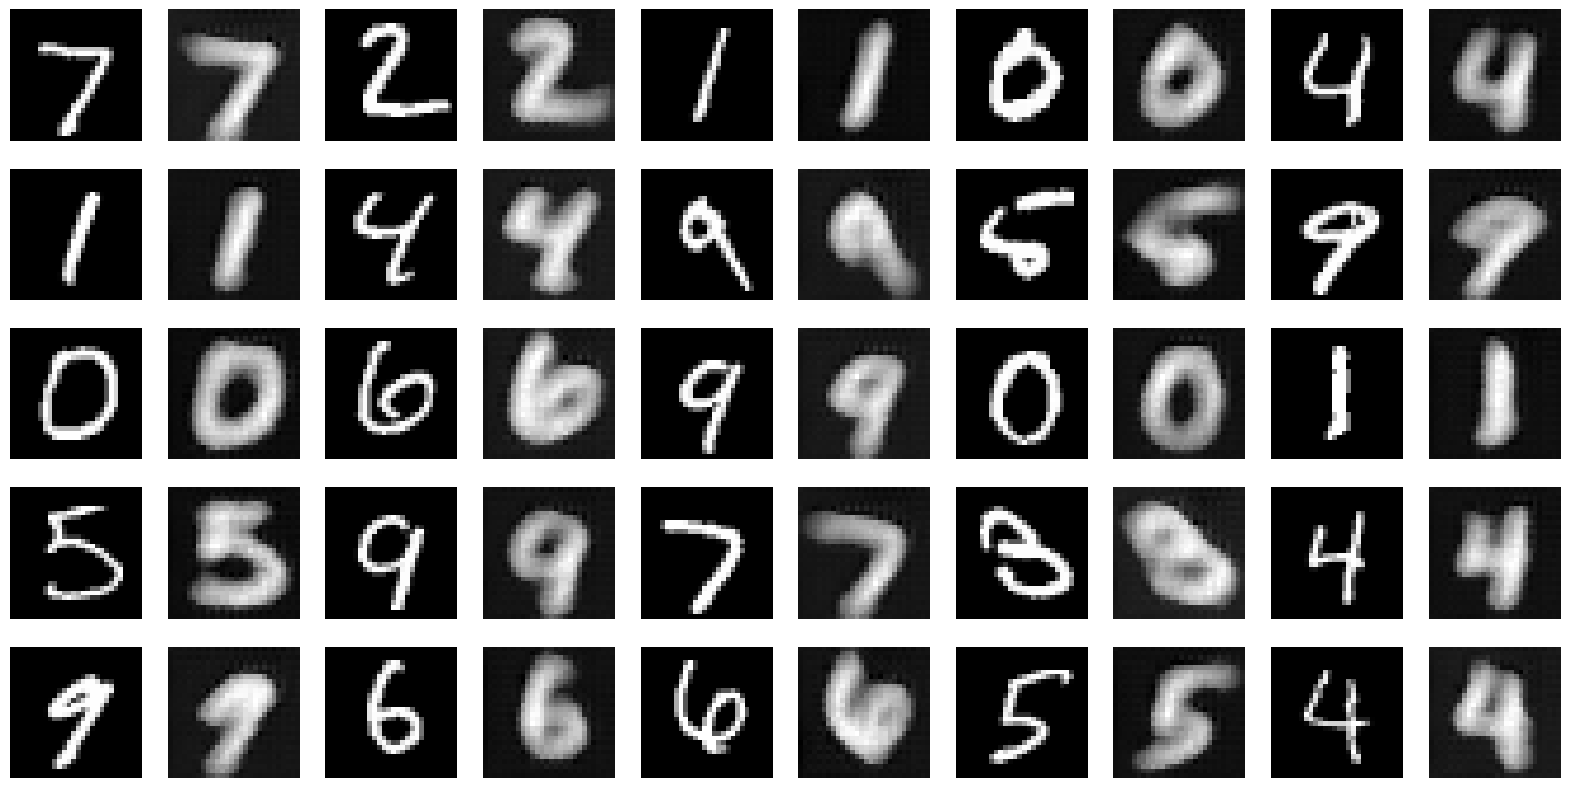

In [ ]:
# Test the model
import numpy as np
images = test_dataset.data[:25]

ae.eval()
with torch.no_grad():
    reconstruction = ae(images.unsqueeze(1).to(torch.float32))
    reconstruction = reconstruction.squeeze(1)
    all_images = []
    for i, j in zip(images, reconstruction):
        all_images.append(i)
        all_images.append(j)
    all_images = torch.FloatTensor(np.array(all_images))
    fig1, axes1 = plt.subplots(5, 10, figsize=(20, 10))
    show_grid(all_images, fig1, axes1)

In [ ]:
class ConvVAE(pl.LightningModule):
    def __init__(self, in_channels = 1,
                 out_channels = 16,
                 latent_dim = 64,
                 act_fn = nn.ReLU(),
                 beta = 5e-3,):
        super().__init__()
        self.beta = beta
        self.encoder = ConvEncoder(in_channels,
                                   out_channels,
                                   latent_dim,
                                   act_fn)
        self.decoder = ConvDecoder(in_channels,
                                   out_channels,
                                   latent_dim,
                                   act_fn)
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_var = nn.Linear(latent_dim, latent_dim)

    def encode(self, x, include_var = False):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        if include_var:
            log_var = self.fc_var(encoded)
            return mu, log_var
        return mu

    def decode(self, z):
        decoded = self.decoder(z)
        return decoded

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x, include_var = True)
        z = self.reparameterize(mu, log_var)
        decoded = self.decode(z)
        return decoded, mu, log_var

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, x_hat, x, mu, log_var):
        reconstruction_loss = F.mse_loss(x_hat, x)
        kl_divergence = -0.5 * \
            torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
        kl_divergence = torch.mean(kl_divergence)
        loss = reconstruction_loss + self.beta * kl_divergence
        return loss, reconstruction_loss, kl_divergence

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mu, log_var = self(x)
        loss, reconstruction_loss, kl_divergence = \
            self.loss(x_hat, x, mu, log_var)
        self.log('train_loss', loss)
        self.log('reconstruction_loss', reconstruction_loss)
        self.log('kl_divergence', kl_divergence)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mu, log_var = self(x)
        loss, reconstruction_loss, kl_divergence = \
            self.loss(x_hat, x, mu, log_var)
        self.log('val_loss', loss)
        self.log('reconstruction_loss', reconstruction_loss)
        self.log('kl_divergence', kl_divergence)
        return loss


    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat, mu, log_var = self(x)
        loss, reconstruction_loss, kl_divergence = \
            self.loss(x_hat, x, mu, log_var)
        self.log('test_loss', loss)
        self.log('reconstruction_loss', reconstruction_loss)
        self.log('kl_divergence', kl_divergence)
        return loss


In [ ]:
# Instantiate the model
vae = ConvVAE()

# Train the model
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=2)
trainer.fit(vae, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | ConvEncoder | 272 K 
1 | decoder | ConvDecoder | 275 K 
2 | fc_mu   | Linear      | 4.2 K 
3 | fc_var  | Linear      | 4.2 K 
----------------------------------------
556 K     Trainable params
0         Non-trainable params
556 K     Total params
2.226     Total estimated model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


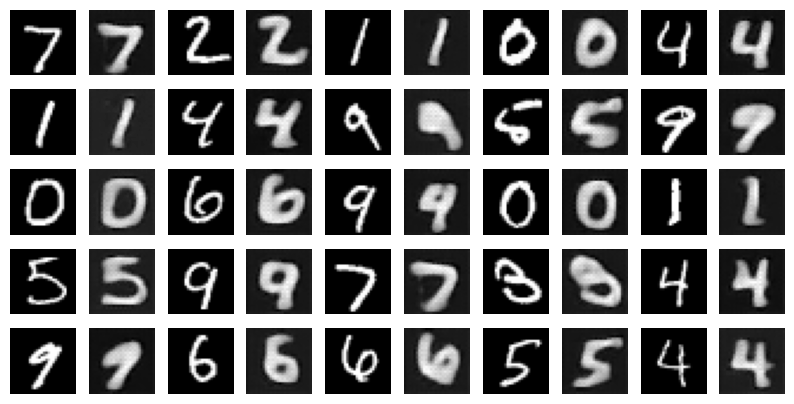

In [ ]:
images = test_dataset.data[:25]

vae.eval()
with torch.no_grad():
    reconstruction, _, _ = vae(images.unsqueeze(1).to(torch.float32))
    reconstruction = reconstruction.squeeze(1)
    all_images = []
    for i, j in zip(images, reconstruction):
        all_images.append(i)
        all_images.append(j)
    all_images = torch.FloatTensor(np.array(all_images))
    fig1, axes1 = plt.subplots(5, 10, figsize=(10, 5))

    show_grid(all_images, fig1, axes1)

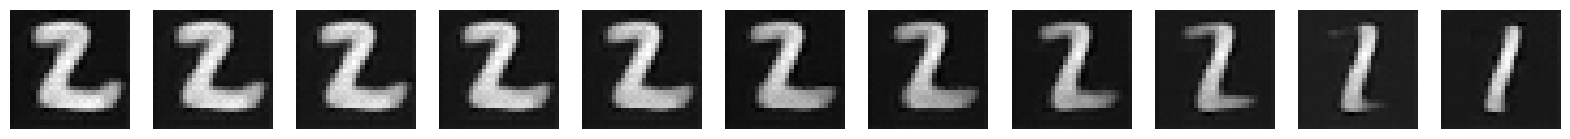

In [ ]:
# Convert between two images
model = vae
i = 1
j = 2
image1 = test_dataset.data[i]
image2 = test_dataset.data[j]
model.eval()
with torch.no_grad():
    encoded1 = model.encode(image1.unsqueeze(0).unsqueeze(0).to(torch.float32))
    encoded2 = model.encode(image2.unsqueeze(0).unsqueeze(0).to(torch.float32))
    diff = encoded2 - encoded1
    images = []
    for k in range(11):
        encoded = encoded1 + k * diff / 10
        decoded = model.decoder(encoded)
        decoded = decoded.squeeze(0).squeeze(0)
        images.append(decoded)
    images = torch.FloatTensor(np.array(images))

    fig, axes = plt.subplots(1, 11, figsize=(20, 10))
    show_grid(images, fig, axes)
